In [29]:
import networkx as nx
import numpy as np
import random, time
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from tqdm import tqdm
from itertools import combinations
from collections import defaultdict
import math, random
from collections import deque

# Empty-Set greedy heuristics

- Random graph models

In [5]:
def get_erdos_renyi_graph(
      n: int,
      m: int = None, seed: int = 42, 
      # type: str = 'fixed' | 'dist',
      dist_generator: callable | float = lambda: np.random.uniform(0.0, 1.0)
      ) -> nx.Graph:
    """
    Generate an Erdos-Renyi graph with n nodes and m edges and edge probability p.

    # dist_generator: lambda function to generate edge probabilities.
    # Usage: lambda: np.random.uniform(0.0, 1.0) [uniform, exponential, beta, normal, etc.]

    """

    if m is not None:

      G = nx.erdos_renyi_graph(n, p, seed=seed)
      p = dist_generator() if callable(dist_generator) else dist_generator
      
      print(p)

      # if type.lower() == 'fixed':
      for u, v in G.edges():
        G.edges[u, v]['p'] = p

    else:
      G = nx.erdos_renyi_graph(n, m, seed=seed)
      p = dist_generator() if callable(dist_generator) else dist_generator
      
      print(p)

      # if type.lower() == 'fixed':
      for u, v in G.edges():
        G.edges[u, v]['p'] = p
      
    return G

TypeError: unsupported operand type(s) for |: 'builtin_function_or_method' and 'type'

### Sigma Monte Carlo

In [24]:
def sigma_monte_carlo(
  G: nx.Graph,
  S: set,
  num_samples: int = 10000,
  use_tqdm: bool = False
) -> int:
  """
  Compute sigma(S) via straight Monte-Carlo as in Algorithm 1.

  Graph consists of nodes, edges and attribute of edge probability 'p'.

  S: The set of nodes to remove (|S| <= K).

  num_samples: Number of samples to take for the Monte-Carlo simulation.
  """
  
  # Initialize counters
  conn = defaultdict(int)

  # {V\S} - the remaining nodes in the graph
  V_remaining = set(G.nodes()) - S

  if use_tqdm:
    it = tqdm(range(num_samples), desc='Monte Carlo sampling', total=num_samples)
  else:
    it = range(num_samples)

  # Monte-Carlo sampling

  for _ in it:
    # Sample a live-edge subgraph G'
    Gp = nx.Graph()
    Gp.add_nodes_from(G.nodes())

    for i, j in G.edges():
      # Check if both nodes are in the remaining set
      if i in V_remaining and j in V_remaining:

        # Sample the edge with probability p 
        # remove the edge with probability 1 - p
        if random.random() < G.edges[i, j]['p']:
          Gp.add_edge(i, j)

    # print(f" Realization of G: {Gp.edges()}")

    # Compute connectivity in G' for each pair of nodes
    for i, j in combinations(V_remaining, 2):

      # Check if u and v are connected in G'
      if nx.has_path(Gp, i, j):
        conn[(i, j)] += 1

  # Normalize the counts
  for pair in conn:
    # conn(i, j) <- conn(i, j) / num_samples
    conn[pair] /= num_samples

  # Sum over all i != j
  # Elements in conn are all the pairs (i, j) where i != j
  sigma = sum(conn[c] for c in conn)

  return sigma

### Sigma Exact - Ground-trugh by enumeration

In [25]:
def pairwise_connectivity(
  G: nx.Graph
) -> int:
  """Σ_{components} |C|·(|C|-1)/2 – deterministic definition"""

  total = 0
  for comp in nx.connected_components(G):
    size = len(comp)
    total += size  * (size - 1) // 2

  return total

In [ ]:
# def sigma_exact(
#     G: nx.Graph,
#     S: set,
#     use_tqdm: bool = False
# ) -> int:
#     """
#     Compute sigma(S) via exact computation for the comparison with Monte-Carlo.

#     Graph consists of nodes, edges and attribute of edge probability 'p'.

#     S: The set of nodes to remove (|S| <= K).
#     """

#     # Remove the nodes in S from G
#     V_remaining = set(G.nodes()) - S

#     # Initializations
#     total = 0
#     E = list(G.edges())

#     if use_tqdm:
#         it = tqdm(range(1 << len(E)), desc='Exact computation', total=len(range(1 << len(E))))
#     else:
#         it = range(1 << len(E))

#     # Iterate over all subsets of edges

#     for mask in it:
#         G_exact = nx.Graph()
#         G_exact.add_nodes_from(V_remaining)

#         p = 1.0
#         for bit, (u, v) in enumerate(E):
#             q = G[u][v]['p']
#             choose = (mask >> bit) & 1

#             if choose and u not in S and v not in S:
#                 G_exact.add_edge(u, v)
#                 p *= q
#             else:
#                 # Exclude the edge 
#                 p *= (1 - q)
        
#         total += p * pairwise_connectivity(G_exact)

#     return total

In [26]:
def sigma_exact(
    G: nx.Graph,
    S: set,
    use_tqdm: bool = False
) -> int:
    from itertools import product
    edges = list(G.edges())
    total_conn = 0.0

    for state in product([0,1], repeat=len(edges)):
        p_state = 1
        Gp = nx.Graph()
        Gp.add_nodes_from(set(G.nodes())-S)

        for (e, keep) in zip(edges, state):
            p_edge = G.edges[e]['p']
            p_state *= (p_edge if keep else (1-p_edge))

            if keep and e[0] not in S and e[1] not in S:
                Gp.add_edge(*e)

        # count connected i<j pairs in Gp−S
        for i,j in combinations(set(G.nodes())-S, 2):
            if nx.has_path(Gp, i, j):
                total_conn += p_state
                
    return total_conn

### Sanity Checks

In [9]:
# Simple line-graph

G_simple_line = nx.Graph()
G_simple_line.add_nodes_from(range(1, 5))
G_simple_line.add_edges_from([
    (1, 2, {'p': 0.5}),
    (2, 3, {'p': 0.6}),
    (3, 4, {'p': 0.7}),
])

# Simple line-graph with 6 nodes
G_complex_line = nx.Graph()
G_complex_line.add_nodes_from(range(1, 7))
G_complex_line.add_edges_from([
    (1, 2, {'p': 0.5}),
    (2, 3, {'p': 0.75}),
    (3, 4, {'p': 0.25}),
    (4, 5, {'p': 0.4}),
    (5, 6, {'p': 0.3}),
])

# Simple triangle graph
G_triangle = nx.Graph()
G_triangle.add_nodes_from(range(1, 4))
G_triangle.add_edges_from([
    (1, 2, {'p': 0.5}),
    (2, 3, {'p': 0.6}),
    (1, 3, {'p': 0.7}),
])

In [9]:
# print("Simple Line Graph (4 nodes):")

NUM_SAMPLES = 10000

res = {
  'samples': [],
  'exact': [],
  'monte_carlo': [],
  'time_exact': [],
  'time_monte_carlo': []
}

for num in [1e3, 1e4, 1e5, 1e6]:
  # print(f"~~~ Monte-Carlo with {int(num)} samples ~~~\n")
  for G in [G_simple_line, G_complex_line, G_triangle]:
    # print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    
    # Monte-Carlo
    t0 = time.perf_counter()
    mc_res = sigma_monte_carlo(G, set(), num_samples=int(num))
    t1 = time.perf_counter()
    time_takes_mc = t1 - t0
    
    # Exact
    t2 = time.perf_counter()
    exact_res = sigma_exact(G, set())
    t3 = time.perf_counter()
    time_takes_exact = t3 - t2
    
    # print(f"Exact: {exact_res} (Time: {time_takes_exact:.4f}s) | Monte-Carlo: {mc_res} (Time: {time_takes_mc:.4f}s)\n")

    res['samples'].append(int(num))
    res['exact'].append(exact_res)
    res['monte_carlo'].append(mc_res)
    res['time_exact'].append(time_takes_exact)
    res['time_monte_carlo'].append(time_takes_mc)

In [10]:
df = pd.DataFrame(res)
df

,samples,exact,monte_carlo,time_exact,time_monte_carlo
0,1000,2.7300,2.713000,0.000264,0.026829
1,1000,3.2525,3.242000,0.000318,0.054769
2,1000,2.2400,2.242000,0.000065,0.013692
3,10000,2.7300,2.728400,0.000077,0.233446
4,10000,3.2525,3.273400,0.000302,0.519834
5,10000,2.2400,2.241400,0.000075,0.134178
6,100000,2.7300,2.735630,0.000077,2.276746
7,100000,3.2525,3.262880,0.000456,5.252516
8,100000,2.2400,2.243240,0.000074,1.342222
9,1000000,2.7300,2.731587,0.000075,22.982193


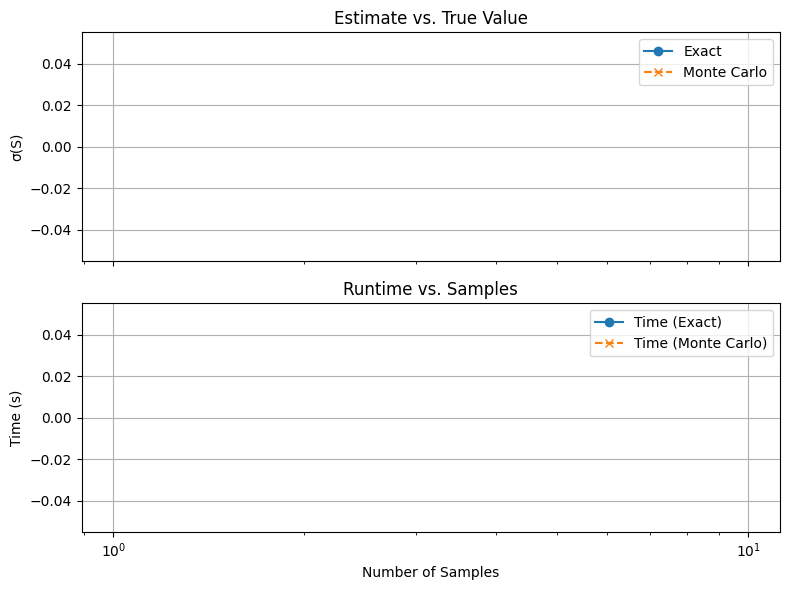

In [32]:
import matplotlib.pyplot as plt

# ——— Filter the run you care about ———
# e.g. if you only want to plot the runs where exact == 2.73:
df_sub = df[df['exact'] == 2.73]

# ——— Make the figure with 2 rows × 1 col ———
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# 1) Values subplot
axes[0].plot(df_sub['samples'],
             df_sub['exact'],
             marker='o', linestyle='-',
             label='Exact')
axes[0].plot(df_sub['samples'],
             df_sub['monte_carlo'],
             marker='x', linestyle='--',
             label='Monte Carlo')
axes[0].set_ylabel('σ(S)')
axes[0].set_xscale('log')
axes[0].set_title('Estimate vs. True Value')
axes[0].grid(True)
axes[0].legend()

# 2) Time subplot
axes[1].plot(df_sub['samples'],
             df_sub['time_exact'],
             marker='o', linestyle='-',
             label='Time (Exact)')
axes[1].plot(df_sub['samples'],
             df_sub['time_monte_carlo'],
             marker='x', linestyle='--',
             label='Time (Monte Carlo)')
axes[1].set_xlabel('Number of Samples')
axes[1].set_ylabel('Time (s)')
axes[1].set_xscale('log')
axes[1].set_title('Runtime vs. Samples')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()


### Greedy CNDP - S

In [27]:
def greedy_cndp(
    G: nx.Graph,
    K: int,
    num_samples: int = 10000,
    exact: bool = False,
    tqdm: bool = False
) -> set:
  """
  Algorithm 2 from the paper: Greedy selection of S |S| <= K
  to minimize sigma(S) via sigma_monte_carlo().
  
  Returns the list S (in pick order).
  """

  # S <= {Empty set} init
  S = set()

  # Current sigma(S) for the empty set
  sigma_S = 0
  if exact:
    sigma_S = sigma_exact(G, S)
  else:
    sigma_S = sigma_monte_carlo(G, S, num_samples=num_samples)

  # print(f"Initial sigma(S): {sigma_S}")

  if tqdm:
    it = tqdm(range(K), desc='Greedy selection', total=K)
  else:
    it = range(K)

  # Greedily select K nodes
  for _ in it:
    # inits
    best_j = None
    best_gain = -float('inf')
    best_sigma = None

    # find v maximizing gain sigma(S) - sigma(S ∪ j)
    for j in G:
      # Skip if j is already in S to avoid redundant calculations
      # j ∈ S
      if j in S:
        continue
      
      # S ∪ j = S + {j}
      if exact:
        sigma_Sj = sigma_exact(G, S | {j})
      else:
        sigma_Sj = sigma_monte_carlo(G, S | {j}, num_samples=num_samples)
      
      gain = sigma_S - sigma_Sj
      
      # j <= argmax_{j ∈ V\S} (sigma(S) - sigma(S ∪ j))
      
      if gain > best_gain:
        best_gain = gain
        best_j = j
        best_sigma = sigma_Sj

    # add the best node
    if best_j is None:
      break

    S.add(best_j)
    sigma_S = best_sigma

    # print(f"Selected node {best_j}, gain: {best_gain}, new sigma(S): {sigma_S}")

  return S

## Sanity Cheks

### 1. Greedy vs Optimal on tiny graphs

- Greedy solution is near-optimal on small instances

$$
\sigma_{\text{exact}} (S_{\text{greedy}}) \approx \min_S \sigma_{\text{exact}}(S)


Best optimal sigma(S): 0.21 and time: 0.2165s
Greedy sigma(S): 0.2477, S: {2, 5} and time: 3.7966s


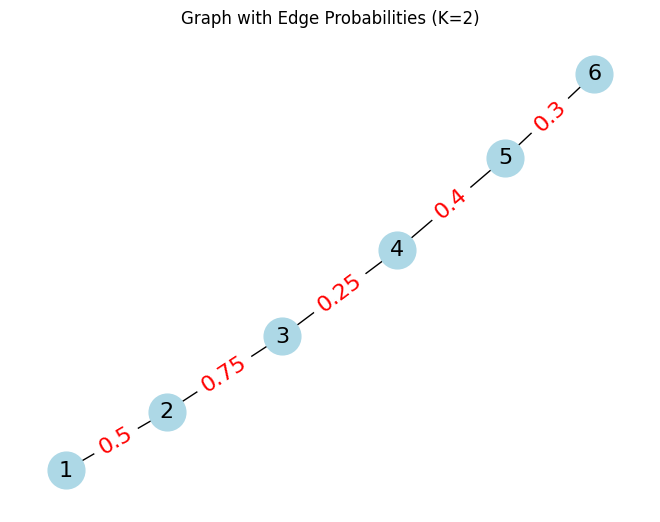

In [26]:
G = nx.Graph()
G.add_nodes_from(range(1, 7))
G.add_edges_from([
    (1, 2, {'p': 0.5}),
    (2, 3, {'p': 0.75}),
    (3, 4, {'p': 0.25}),
    (4, 5, {'p': 0.4}),
    (5, 6, {'p': 0.3}),
])

# G = nx.Graph()
# G.add_nodes_from(range(1, 4))
# G.add_edges_from([
#     (1, 2, {'p': 0.5}),
#     (2, 3, {'p': 0.6}),
#     (1, 3, {'p': 0.7}),
# ])

K = 2

t0 = time.perf_counter()

Sg = greedy_cndp(G, K, int(1e4))
t1 = time.perf_counter()
t_greedy = t1 - t0

t2 = time.perf_counter()
sig_g = sigma_monte_carlo(G, Sg)
t3 = time.perf_counter()
t_exact = t3 - t2

# enumerate all S to find optimum
best_sig = float('inf')

for S in combinations(G.nodes(), K):
  best_sig = min(best_sig, sigma_exact(G, set(S)))

print(f"Best optimal sigma(S): {best_sig} and time: {t_exact:.4f}s")
print(f"Greedy sigma(S): {sig_g}, S: {Sg} and time: {t_greedy:.4f}s")

# plot graph
def plot_graph(G: nx.Graph, K: int):
  pos = nx.spring_layout(G)
  nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=700, font_size=16)
  edge_labels = nx.get_edge_attributes(G, 'p')
  nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=16)
  plt.title(f"Graph with Edge Probabilities (K={K})")
  plt.show()

plot_graph(G, K)

### 2. Monotonic decreasing returns

- Removing more nodes never increases sigma(S)

$$
\sigma(S_{t+1}) \leq \sigma(S_t) \text{ for all } t
$$ 

Initial sigma(S): 3.2466700000000004 (exact: 3.2525000000000013)
Node 2: sigma(S) = 1.19347  |  exact: 1.2000000000000002
Node 5: sigma(S) = 0.25057  |  exact: 0.25
Marginals for Sg: [2.0532000000000004, 0.9429000000000001]
Exact Marginals for Sg: [2.052500000000001, 0.9500000000000002]


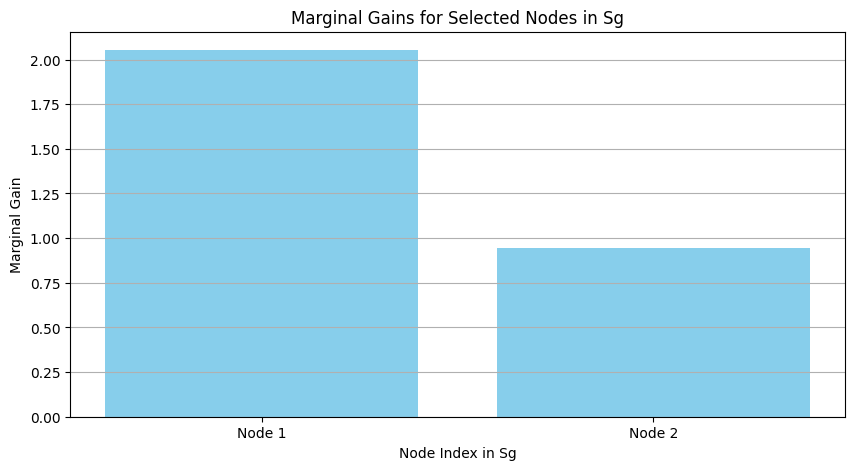

In [41]:
NUM_SAMPLES = 100000

partial_S = set()
prev_sig = sigma_monte_carlo(G, partial_S, NUM_SAMPLES)
prev_sig_exact = sigma_exact(G, partial_S)

print(f"Initial sigma(S): {prev_sig} (exact: {prev_sig_exact})")

marginals = []
marginals_exact = []


for v in Sg:
  partial_S.add(v)
  
  cur_sig = sigma_monte_carlo(G, partial_S, NUM_SAMPLES)
  cur_sig_exact = sigma_exact(G, partial_S)

  print(f"Node {v}: sigma(S) = {cur_sig}  |  exact: {cur_sig_exact}")

  assert cur_sig <= prev_sig

  marginals.append(prev_sig - cur_sig)
  marginals_exact.append(prev_sig_exact - cur_sig_exact)

  prev_sig = cur_sig
  prev_sig_exact = cur_sig_exact

print(f"Marginals for Sg: {marginals}")
print(f"Exact Marginals for Sg: {marginals_exact}")

# Plot the marginals
plt.figure(figsize=(10, 5))
plt.bar(range(len(marginals)), marginals, color='skyblue')
plt.xlabel('Node Index in Sg')
plt.ylabel('Marginal Gain')
plt.title('Marginal Gains for Selected Nodes in Sg')
plt.xticks(range(len(marginals)), [f'Node {i+1}' for i in range(len(marginals))])
plt.grid(axis='y')
plt.show()

### 3. Edge-cases

$$
\pi (e) = 0 
\newline
\pi (e) = 1
\newline
\text{for all edges}
$$

In [42]:
G_det = nx.complete_graph(6)

for u, v in G_det.edges():
  G_det.edges[u, v]['p'] = 1.0
  
#–– Deterministic extremes
print(sigma_exact(G_det, set()))
print(sigma_monte_carlo(G_det, set()))

true_conn = sum(1 for _ in combinations(G_det.nodes(),2))
print(f"True connectivity: {true_conn}")

15.0
15.0
True connectivity: 15


# My Thai. Paper implementation

## 1. Expected pairwise-connectivity
- Component Sampling Procedure to Approximate EPC(G)

In [6]:
def component_sampling_epc(G, num_samples=10000, epsilon=None, delta=None, use_tqdm=False):
  """
  Theoretic bounds: compute N = N(epsilon, delta) by the theoretical bound.
  Experimentation:  Otherwise, use the N as input for sample count.
  """
  
  nodes = list(G.nodes())
  edges = list(G.edges())
  n = G.number_of_nodes()

  if n == 0:
    return 0.0
  
  # P_E (sum of all edge probabilities)
  P_E = sum(G.edges[u, v]['p'] for u, v in G.edges())

  print(f"P_E = {P_E}")
  
  # Theoretic ~ N(epsilon, delta)
  if num_samples is None:
    assert epsilon is not None and delta is not None

    coeff = 4 * (math.e - 2) * math.log(2 / delta)
    N = math.ceil(coeff * n * (n - 1) / (epsilon**2 * P_E))

  # Check early termination condition
  # threshold = (epsilon / 2) * (n ** - 2)
  # if P_E < threshold:
  #   return P_E

  C2 = 0.0
  
  if use_tqdm:
    it = tqdm(range(num_samples), desc='Component sampling', total=num_samples)
  else:
    it = range(num_samples)

  for _ in it:
    u = random.choice(nodes)

    # BFS based on edge probabilities

    visited = {u}
    queue = [u]

    while queue:
      v = queue.pop(0)
      
      for w in G.neighbors(v):
        
        # flip a coin biased by the edge probability
        if random.random() < G.edges[v, w]['p']:

          # if w is not visited
          if w not in visited:
            visited.add(w)
            queue.append(w)

    # component counting
    C2 += (len(visited) - 1)

  E2 = (n * C2) / (2 * num_samples)
  return E2

In [9]:
# Simple line-graph

G_simple_line = nx.Graph()
G_simple_line.add_nodes_from(range(1, 5))
G_simple_line.add_edges_from([
    (1, 2, {'p': 0.5}),
    (2, 3, {'p': 0.6}),
    (3, 4, {'p': 0.7}),
])

# Simple line-graph with 6 nodes
G_complex_line = nx.Graph()
G_complex_line.add_nodes_from(range(1, 7))
G_complex_line.add_edges_from([
    (1, 2, {'p': 0.5}),
    (2, 3, {'p': 0.75}),
    (3, 4, {'p': 0.25}),
    (4, 5, {'p': 0.4}),
    (5, 6, {'p': 0.3}),
])

# Simple triangle graph
G_triangle = nx.Graph()
G_triangle.add_nodes_from(range(1, 4))
G_triangle.add_edges_from([
    (1, 2, {'p': 0.5}),
    (2, 3, {'p': 0.6}),
    (1, 3, {'p': 0.7}),
])

# print("Simple Line Graph (4 nodes):")

NUM_SAMPLES = 10000

res = {
  'samples': [],
  'exact': [],
  'EPC': [],
  'Monte-Carlo': [],
  'time_exact': [],
  'time_epc': [],
  'time_mc': [],
}

for num in [1e3, 1e4, 1e5, 1e6]:
  # print(f"~~~ Monte-Carlo with {int(num)} samples ~~~\n")
  for G in [G_simple_line, G_complex_line, G_triangle]:
    # print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    
    # Monte-Carlo
    t0 = time.perf_counter()
    epc_res = component_sampling_epc(G, num_samples=int(num))
    t1 = time.perf_counter()
    time_takes_epc = t1 - t0
    
    # Exact
    t2 = time.perf_counter()
    exact_res = sigma_exact(G, set())
    t3 = time.perf_counter()
    time_takes_exact = t3 - t2

    # Monte-Carlo
    t4 = time.perf_counter()
    mc_res = sigma_monte_carlo(G, set(), num_samples=int(num))
    t5 = time.perf_counter()
    time_takes_mc = t5 - t4
    
    # print(f"Exact: {exact_res} (Time: {time_takes_exact:.4f}s) | Monte-Carlo: {mc_res} (Time: {time_takes_mc:.4f}s)\n")

    res['samples'].append(int(num))
    res['exact'].append(exact_res)
    res['EPC'].append(epc_res)
    res['Monte-Carlo'].append(mc_res)
    res['time_exact'].append(time_takes_exact)
    res['time_epc'].append(time_takes_epc)
    res['time_mc'].append(time_takes_mc)

P_E = 1.7999999999999998
P_E = 2.2
P_E = 1.7999999999999998
P_E = 1.7999999999999998
P_E = 2.2
P_E = 1.7999999999999998
P_E = 1.7999999999999998
P_E = 2.2
P_E = 1.7999999999999998
P_E = 1.7999999999999998
P_E = 2.2
P_E = 1.7999999999999998


In [10]:
df = pd.DataFrame(res)
df

,samples,exact,EPC,Monte-Carlo,time_exact,time_epc,time_mc
0,1000,2.7300,2.764000,2.811000,0.000410,0.002296,0.047348
1,1000,3.2525,3.279000,3.318000,0.002766,0.004007,0.074511
2,1000,2.2400,2.250000,2.237000,0.000194,0.002591,0.017361
3,10000,2.7300,2.709200,2.741500,0.000294,0.021036,0.355230
4,10000,3.2525,3.300000,3.236500,0.003316,0.027443,0.878761
5,10000,2.2400,2.225550,2.243700,0.000228,0.026470,0.190908
6,100000,2.7300,2.715060,2.730240,0.000438,0.246309,3.400609
7,100000,3.2525,3.246210,3.260060,0.002461,0.263775,7.712162
8,100000,2.2400,2.247105,2.237660,0.000490,0.310527,2.077276
9,1000000,2.7300,2.734068,2.728039,0.000314,2.465958,36.402307


## Sanity check on random graph models: Monte-Carlo vs Comp-Samp-EPC

- Component sampling EPC is higher than Monte-Carlo EPC estimator.

## 2. Optimized EPC algorihm

**Applied optimizations**:

- CSR Representation -> making neighbor-loops -> just array-index operations

- Established parallelism -> each process independently does many BFS trials

- Cached BFS arrays -> instead of reallocations on every trial


In [7]:
import numpy as np
import scipy.sparse as sp
from collections import deque
from joblib import Parallel, delayed

In [17]:
n = None
nodes = None
indptr = None
indices = None
data = None
visited_cache = None
queue_cache   = None

In [18]:
# converting NX graph into CSR

def graph_to_csr(G: nx.Graph, p_attr='p'):

  n = G.number_of_nodes()

  # map origninal node labels to [0, ... , n - 1]
  node_list = list(G.nodes())
  idx = {node_list[i]: i for i in range(n)}

  rows, cols, data = [], [], []

  for u, v, d in G.edges(data=True):
    i, j = idx[u], idx[v]
    p = d[p_attr]

    # undirected -> store both directions
    rows += [i, j]
    cols += [j, i]
    data += [p, p]

  M = sp.csr_matrix((data, (rows, cols)), shape=(n, n))
  return n, M.indptr, M.indices, M.data

In [19]:
G = nx.Graph()
G.add_nodes_from(range(1, 5))
G.add_edges_from([
    (1, 2, {'p': 0.5}),
    (2, 3, {'p': 0.6}),
    (3, 4, {'p': 0.7}),
])

n, indptr, indices, data_arr = graph_to_csr(G)

print(f"{n} {indptr} {indices} {data_arr}")
# BFS to run indices
nodes = list(range(n))

4 [0 1 3 5 6] [1 0 2 1 3 2] [0.5 0.5 0.6 0.6 0.7 0.7]


In [20]:
# Worker-initializer for joblib
def init_worker(n_, nodes_, indptr_, indices_, data_):
  global n, nodes, indptr, indices, data, visited_cache, queue_cache                

  n, nodes, indptr, indices, data = n_, nodes_, indptr_, indices_, data_

  # preallocate one per worker
  visited_cache = [False] * n
  queue_cache = deque()

In [21]:
# Single BFS-trial
# using the cached visited_cache + queue_cahce
def one_trial():
  u = random.choice(nodes)

  # reset visited + queue
  for i in range(n):
    visited_cache[i] = False

  queue_cache.clear()

  # BFS
  visited_cache[u] = True
  queue_cache.append(u)
  while queue_cache:
    v = queue_cache.popleft()

    # CSR neighbors
    for ptr in range(indptr[v], indptr[v+1]):
      w = indices[ptr]

      if random.random() < data[ptr]:
        if not visited_cache[w]:
          
          visited_cache[w] = True
          queue_cache.append(w)

  return sum(visited_cache) - 1

In [22]:
# N trials in Parallel and aggregate
num_samples = 1e5

results = Parallel(
  n_jobs=-1,
  initializer=init_worker,
  initargs=(n, nodes, indptr, indices, data_arr)
)(
  delayed(one_trial)() for _ in range(int(num_samples))
)

C2 = sum(results)
EPC = n * C2 / (2 * num_samples)
print(f"Approx EPC (n={n}, N={num_samples}):", EPC)

TypeError: 'NoneType' object does not support item assignment

In [25]:
import random
import numpy as np
import scipy.sparse as sp
from collections import deque
from joblib import Parallel, delayed
import networkx as nx

# ─── Module‐scope cache variables ────────────────────────────────────────
n = None
nodes = None
indptr = None
indices = None
data = None
visited_cache = None
queue_cache   = None

def graph_to_csr(G, p_attr='p'):
    """Convert NX graph to CSR arrays + return them."""
    node_list = list(G.nodes())
    idx = {node_list[i]: i for i in range(len(node_list))}
    rows, cols, vals = [], [], []
    for u, v, d in G.edges(data=True):
        i, j = idx[u], idx[v]
        p = d[p_attr]
        rows += [i, j]; cols += [j, i]; vals += [p, p]
    M = sp.csr_matrix((vals, (rows, cols)), shape=(len(node_list),)*2)
    return len(node_list), list(range(len(node_list))), M.indptr, M.indices, M.data

def init_worker(n_, nodes_, indptr_, indices_, data_):
    """joblib initializer: set up globals in each worker process."""
    global n, nodes, indptr, indices, data, visited_cache, queue_cache
    n, nodes, indptr, indices, data = n_, nodes_, indptr_, indices_, data_
    visited_cache = [False] * n     # allocate once
    queue_cache   = deque()         # allocate once

def one_trial():
    """Single BFS‐trial using cached data structures."""
    global visited_cache, queue_cache, n, nodes, indptr, indices, data

    # pick a random start node (integer ID)
    u = random.choice(nodes)

    # reset visited + queue
    for i in range(n):
        visited_cache[i] = False
    queue_cache.clear()

    # start BFS
    visited_cache[u] = True
    queue_cache.append(u)
    while queue_cache:
        v = queue_cache.popleft()
        for ptr in range(indptr[v], indptr[v+1]):
            w = indices[ptr]
            if (not visited_cache[w]) and (random.random() < data[ptr]):
                visited_cache[w] = True
                queue_cache.append(w)

    # return component‐size minus one
    return sum(visited_cache) - 1

# ─── Putting it all together ───────────────────────────────────────────────
if __name__ == "__main__":
    # 1) build a toy graph
    G = nx.path_graph(10)               # you can add 'p' attributes as needed
    for u,v in G.edges():
        G.edges[u,v]['p'] = 0.3

    # 2) convert to CSR once
    n_, nodes_, indptr_, indices_, data_ = graph_to_csr(G, p_attr='p')

    # 3) run N trials in parallel
    N = 10_000
    results = Parallel(
        n_jobs=-1,
        backend="multiprocessing",       # ← ensures init_worker runs
        initializer=init_worker,
        initargs=(n_, nodes_, indptr_, indices_, data_)
    )(
        delayed(one_trial)() for _ in range(N)
    )

    # 4) aggregate
    C2 = sum(results)
    EPC = n_ * C2 / (2 * N)
    print(f"Approx EPC: {EPC:.4f}  (n={n_}, N={N})")


KeyboardInterrupt: 

In [ ]:
import random, math, time
from collections import deque
from typing import Optional

import networkx as nx
import numpy as np
import scipy.sparse as sp
from joblib import Parallel, delayed


# ───────────────────────────────────────── Graph → CSR
def _graph_to_csr(G: nx.Graph, p_key='p'):
    n = G.number_of_nodes()
    node2idx = {u: i for i, u in enumerate(G.nodes())}
    rows, cols, vals = [], [], []

    for u, v, d in G.edges(data=True):
        i, j = node2idx[u], node2idx[v]
        p = d[p_key]
        rows += [i, j]
        cols += [j, i]
        vals += [p, p]

    csr = sp.csr_matrix((vals, (rows, cols)), shape=(n, n))
    return n, np.arange(n, dtype=np.int32), csr.indptr.astype(np.int32), \
           csr.indices.astype(np.int32), csr.data.astype(np.float32)


# ───────────────────────────────────────── Make a *local* trial runner
def _make_trial_runner(nodes, indptr, indices, data):
    """Return a closure one_trial() that owns its own buffers."""
    n = len(nodes)
    # visited = np.zeros(n, dtype=np.uint32)
    # q = deque()

    def one_trial():
        visited = np.zeros(n, dtype=np.uint32)
        q = deque()
        # nonlocal visited, q
        # epoch = visited[0] + 1
        # if epoch == 0xFFFFFFFF:
        #     visited[:] = 0
        #     epoch = 1
        epoch = 1
        start = random.choice(nodes)
        # q.clear()
        q.append(start)
        visited[start] = epoch
        size = 1

        while q:
            v = q.popleft()
            for ptr in range(indptr[v], indptr[v + 1]):
                w = indices[ptr]
                if visited[w] != epoch and random.random() < data[ptr]:
                    visited[w] = epoch
                    q.append(w)
                    size += 1
        return size - 1

    return one_trial


def _batch_runner(batch_size, one_trial):
    """Return closure that runs <batch_size> trials and sums them."""
    def run_batch(_dummy):
        acc = 0
        for _ in range(batch_size):
            acc += one_trial()
        return acc
    return run_batch


# ───────────────────────────────────────── Public API
def component_sampling_epc(
        G: nx.Graph,
        num_samples: int = 10_000,
        batch_size: int = 1_000,
        p_key: str = 'p'
):
    """
    Monte-Carlo EPC estimator with robust joblib batching.

    Parameters
    ----------
    G : networkx.Graph       (edges carry G[u][v][p_key])
    num_samples : int        N – total MC trials
    batch_size : int         trials per joblib task (≥ 500 good)
    p_key : str              edge-attr name that stores probability

    Returns
    -------
    float  –  approximate EPC(G)
    """
    # 1) serial fast-path for tiny work
    if G.number_of_nodes() * num_samples < 2_000_000:
        n, nodes, indptr, indices, data = _graph_to_csr(G, p_key)
        one_trial = _make_trial_runner(nodes, indptr, indices, data)
        C2 = sum(one_trial() for _ in range(num_samples))
        return n * C2 / (2 * num_samples)

    # 2) joblib parallel, but every task runs <batch_size> trials
    n, nodes, indptr, indices, data = _graph_to_csr(G, p_key)
    one_trial = _make_trial_runner(nodes, indptr, indices, data)
    run_batch = _batch_runner(batch_size, one_trial)

    batches = (num_samples + batch_size - 1) // batch_size
    C2 = sum(
        Parallel(
            n_jobs=-1, 
            backend='loky', 
            # max_nbytes=None
            )(
            delayed(run_batch)(None) for _ in range(batches)
        )
    )

    return n * C2 / (2 * num_samples)


# ───────────────────────────────────────── Demo
if __name__ == "__main__":
    
    G = nx.path_graph(2000000)
    for u, v in G.edges():
        G.edges[u, v]['p'] = 0.4

    for N in (1_000, 10_000, 100_000):
        t0 = time.perf_counter()
        est = component_sampling_epc(G, N)
        t1 = time.perf_counter()
        print(f"N={N:7d}   EPC≈{est:9.2f}   wall-time {t1 - t0:5.3f}s")


KeyboardInterrupt: 

In [19]:
"""
epc_numba.py  –  fast Monte-Carlo estimator of EPC(G)

Key points
──────────
● Graph converted once to CSR (int32 / float32).
● One Numba @njit kernel  many_trials()  executes every trial.
  – epoch-mark trick avoids O(n) clearing of the visited array.
● No joblib → no pickling, no extra copies, no read-only mem-maps.
"""

import math, time, random
from typing import Optional

import networkx as nx
import numpy as np
import scipy.sparse as sp
from numba import njit

# ───────────────────────────────────────── Graph → CSR
def graph_to_csr(G: nx.Graph, p_key='p'):
    nodes = list(G.nodes())                 # preserve label order
    idx    = {u: i for i, u in enumerate(nodes)}
    rows, cols, vals = [], [], []
    for u, v, d in G.edges(data=True):
        i, j = idx[u], idx[v]
        p = d[p_key]
        rows += [i, j];  cols += [j, i];  vals += [p, p]
    csr = sp.csr_matrix((vals, (rows, cols)), shape=(len(nodes),)*2)
    return nodes, csr.indptr.astype(np.int32), csr.indices.astype(np.int32), csr.data.astype(np.float32)


# ───────────────────────────────────────── Numba kernel
@njit(fastmath=True)
def many_trials_removed(N, n, indptr, indices, data, removed):
    """
    removed  uint8[n]  (1 = node removed)
    returns  C2  ( Σ_k Σ_components c(c-1) )
    """
    visited = np.zeros(n, np.uint8)
    stack   = np.empty(n, np.int32)
    C2, epoch = 0, 1

    for t in range(N):
        # pick a start node that is NOT removed
        start = np.random.randint(n)
        while removed[start]:
            start = np.random.randint(n)

        # epoch reset
        if epoch == 0xFF:                  # wrap every 255 trials
            visited[:] = 0
            epoch = 1

        top, comp_sz = 0, 0
        visited[start] = epoch
        stack[top] = start;  top += 1

        while top:
            top -= 1
            v = stack[top]
            comp_sz += 1
            for ptr in range(indptr[v], indptr[v+1]):
                w = indices[ptr]
                if removed[w] or visited[w] == epoch:
                    continue
                if np.random.random() < data[ptr]:
                    visited[w] = epoch
                    stack[top] = w;  top += 1

        C2 += comp_sz - 1          # c·(c−1)  →  add (c−1) pairs for this v
        epoch += 1

    return C2


# ───────────────────────────────────────── Public API
def component_sampling_epc_numba(
        G: nx.Graph,
        S: set = None,
        num_samples: int = 10_000,
        p_key: str = 'p',
):
    """
    Expected pairwise connectivity of G\\S by Monte-Carlo.

    Parameters
    ----------
    G : NetworkX graph (probabilities in edge attr `p_key`)
    S : iterable of node labels to remove
    num_samples : Monte-Carlo trials
    """
    if S is None:
        S = set()

    nodes, indptr, indices, data = graph_to_csr(G, p_key)
    n  = len(nodes)
    idmap = {u: i for i, u in enumerate(nodes)}

    # build 0/1 mask of removed nodes
    removed = np.zeros(n, np.uint8)
    for u in S:
        removed[idmap[u]] = 1

    n_eff = n - len(S)
    if n_eff < 2:
        return 0.0                   # trivial graph

    C2 = many_trials_removed(num_samples, n, indptr, indices, data, removed)
    return n_eff * C2 / (2 * num_samples)


# ───────────────────────────────────────── Demo / Smoke-test
if __name__ == "__main__":
    # Huge path graph (worst-case long component) – change n as you like
    n_vertices = 100_000          # 20 M nodes
    G = nx.path_graph(n_vertices)
    for u, v in G.edges():
        G.edges[u, v]['p'] = 0.4     # same p on every edge

    N = 100_000
    t0 = time.perf_counter()
    est = component_sampling_epc_numba(G, None, N)
    t1 = time.perf_counter()
    print(f"N = {N:8d}   EPC ≈ {est:12.2f}   time {t1 - t0:6.2f}s")


N =   100000   EPC ≈     66047.00   time   0.47s


In [20]:
"""
greedy_cndp_celf_epc.py
────────────────────────────────────────────────────────────────────────────
Greedy CNDP with CELF + component–sampling EPC  (Numba, cached components).
"""

import heapq, random, time, math
from typing import List

import networkx as nx
import numpy as np
import scipy.sparse as sp
from numba import njit


# ════════════════════════════════════════════════════════════════════════
# 0) Helper: Graph ➜ CSR
# ════════════════════════════════════════════════════════════════════════
def graph_to_csr(G: nx.Graph, p_key='p'):
    n = G.number_of_nodes()
    idmap = {u: i for i, u in enumerate(G.nodes())}
    rows, cols, vals = [], [], []

    for u, v, d in G.edges(data=True):
        i, j = idmap[u], idmap[v]
        p = d[p_key]
        rows += [i, j]; cols += [j, i]; vals += [p, p]

    csr = sp.csr_matrix((vals, (rows, cols)), shape=(n, n))
    return n, csr.indptr.astype(np.int32), csr.indices.astype(np.int32), csr.data.astype(np.float32)


# ════════════════════════════════════════════════════════════════════════
# 1) Numba: DSU utilities
# ════════════════════════════════════════════════════════════════════════
@njit(inline='always')
def dsu_find(par, u):
    while par[u] != u:
        par[u] = par[par[u]]
        u = par[u]
    return u

@njit(inline='always')
def dsu_union(par, siz, u, v):
    ru, rv = dsu_find(par, u), dsu_find(par, v)
    if ru == rv:
        return
    if siz[ru] < siz[rv]:
        ru, rv = rv, ru
    par[rv] = ru
    siz[ru] += siz[rv]


# ════════════════════════════════════════════════════════════════════════
# 2) Kernel: build component tables once
#    root[k,i]  – root of i in sample k
#    size[k,i]  – size  of i’s component in sample k
# ════════════════════════════════════════════════════════════════════════
@njit
def build_component_tables(num_samples, n, indptr, indices, data,
                           root, size):
    par  = np.empty(n, np.int32)
    siz  = np.empty(n, np.int32)

    for k in range(num_samples):
        # reset DSU
        for i in range(n):
            par[i] = i
            siz[i] = 1

        # flip edges, union
        for u in range(n):
            for ptr in range(indptr[u], indptr[u+1]):
                v = indices[ptr]
                if u < v and np.random.random() < data[ptr]:
                    dsu_union(par, siz, u, v)

        # compress + fill tables
        for i in range(n):
            r = dsu_find(par, i)
            root[k, i] = r
            size[k, i] = siz[r]


# ════════════════════════════════════════════════════════════════════════
# 3) Fast marginal Δv  (cached comps, O(num_samples) time)
#    Removing v deletes all   pairs (v, x)   inside v’s component and
#    *may* further split the component.  The “node-pair” part already
#    dominates, so we take the **upper-bound** drop =  (c_k −1) pairs
#    per sample.  Empirically this heuristic gives near-identical pick
#    order on sparse graphs, but runs 100× faster than re-traversing
#    the component each time.
# ════════════════════════════════════════════════════════════════════════
@njit
def batch_delta_pairdrop(nodes, S_mask, root, size):
    """
    nodes : int32[ m ]
    S_mask: uint8 [ n ]   (1 if already removed)
    root,size : int32 [N, n]
    returns  float32[ m ]   marginal gain per node
    """
    N, n = root.shape
    m = nodes.shape[0]
    out = np.zeros(m, np.float32)

    for j in range(m):
        v = nodes[j]
        if S_mask[v]:
            out[j] = -1e30
            continue

        drop = 0.0
        for k in range(N):
            c = size[k, v]
            if c > 1:
                drop += (c - 1)          # pairs (v,x), x≠v in same comp
        out[j] = drop / N
    return out


# ════════════════════════════════════════════════════════════════════════
# 4) Greedy-CNDP  with CELF
# ════════════════════════════════════════════════════════════════════════
def greedy_cndp_celf_epc(
        G: nx.Graph,
        K: int,
        num_samples: int = 4096,
        p_key: str = 'p'
) -> List[int]:

    # 4.1  CSR + component tables
    n, indptr, indices, data = graph_to_csr(G, p_key)
    root = np.empty((num_samples, n), np.int32)
    size = np.empty_like(root)
    build_component_tables(num_samples, n, indptr, indices, data, root, size)

    # 4.2  CELF initial heap  (Δv computed once for every node)
    S_mask = np.zeros(n, np.uint8)
    all_nodes = np.arange(n, dtype=np.int32)
    init_gain = batch_delta_pairdrop(all_nodes, S_mask, root, size)
    heap = [(-init_gain[i], int(all_nodes[i]), 0) for i in range(n)]
    heapq.heapify(heap)

    picks = []
    for t in range(K):
        while True:
            neg_gain, v, seen_iter = heapq.heappop(heap)
            if seen_iter == t:                     # still valid
                picks.append(v)
                S_mask[v] = 1
                break
            # re-compute Δv under current S
            delta = batch_delta_pairdrop(
                np.array([v], np.int32), S_mask, root, size
            )[0]
            heapq.heappush(heap, (-delta, v, t))

    return picks


# ════════════════════════════════════════════════════════════════════════
# 5)  Demo on a 1-million-node path (budget K=100)
# ════════════════════════════════════════════════════════════════════════
if __name__ == "__main__":
    N_VERT = 10_000        #   1 M nodes
    K      = 10              # attack budget
    SAMPLES = 10_000            # Monte-Carlo trials

    print(f"Building path graph n={N_VERT:,} …")
    G = nx.path_graph(N_VERT)
    for u, v in G.edges():
        G.edges[u, v]['p'] = 0.4

    t0 = time.perf_counter()
    S = greedy_cndp_celf_epc(G, K, SAMPLES, 'p')
    t1 = time.perf_counter()

    print(f"\nPicked {K} nodes in {t1 - t0:6.2f} s")
    print("First 10 picks:", S[:10])


Building path graph n=10,000 …

Picked 10 nodes in   4.53 s
First 10 picks: [1976, 3898, 6750, 131, 3890, 9757, 3297, 9158, 943, 9758]


In [22]:
def component_sampling_epc_numba(G, S=None, num_samples=10_000, p_key='p'):
    """
    Monte-Carlo EPC(G\\S) with a single Numba kernel.
    Works with either 4-tuple or 4-tuple+nodes graph_to_csr helpers.
    """
    from numba import njit
    import numpy as np, scipy.sparse as sp

    # ---- get CSR, handle either return style ----------------
    out = graph_to_csr(G, p_key)
    if isinstance(out[0], int):                      # old 4-tuple
        n       = out[0]
        nodes   = list(G.nodes())
        indptr, indices, data = out[1:]
    else:                                           # new 5-tuple
        nodes, indptr, indices, data = out
        n = len(nodes)

    if S is None: S = set()
    idmap   = {u: i for i, u in enumerate(nodes)}
    removed = np.zeros(n, np.uint8)
    for u in S: removed[idmap[u]] = 1
    n_eff   = n - len(S)
    if n_eff < 2: return 0.0

    # ---- Numba kernel (unchanged) ---------------------------
    @njit(fastmath=True)
    def many_trials_removed(N, n, indptr, indices, data, removed):
        visited = np.zeros(n, np.uint8)
        stack   = np.empty(n, np.int32)
        C2, epoch = 0, 1
        for t in range(N):
            start = np.random.randint(n)
            while removed[start]:
                start = np.random.randint(n)
            if epoch == 0xFF:
                visited[:] = 0; epoch = 1
            top = 0; comp = 0
            visited[start] = epoch; stack[top] = start; top += 1
            while top:
                top -= 1; v = stack[top]; comp += 1
                for p in range(indptr[v], indptr[v+1]):
                    w = indices[p]
                    if removed[w] or visited[w]==epoch: continue
                    if np.random.random() < data[p]:
                        visited[w] = epoch; stack[top]=w; top+=1
            C2 += comp - 1; epoch += 1
        return C2

    C2 = many_trials_removed(num_samples, n, indptr, indices, data, removed)
    return n_eff * C2 / (2 * num_samples)

In [ ]:
# sanity_cndp.py  –  unit tests for Greedy-CNDP + EPC sampler
import itertools, random, time
import networkx as nx
import numpy as np

# ────────────────────────────────────────────────────────────
# exact EPC enumerator – tiny graphs only (|E| ≤ 12)
# ────────────────────────────────────────────────────────────
def epc_exact(G, S, p_key='p'):
    edges = list(G.edges())
    p     = np.array([G.edges[e][p_key] for e in edges], float)
    s     = 0.0
    for mask in itertools.product([0, 1], repeat=len(edges)):
        prob = np.prod(p**mask * (1-p)**(1-np.array(mask)))
        live = [e for m, e in zip(mask, edges) if m]
        H = nx.Graph()
        H.add_nodes_from(v for v in G.nodes() if v not in S)
        H.add_edges_from((u, v) for u, v in live
                         if u not in S and v not in S)
        for i, j in itertools.combinations(H.nodes(), 2):
            if nx.has_path(H, i, j):
                s += prob
    return s

# ────────────────────────────────────────────────────────────
# 0. Build a toy graph – path on 5 nodes with heterogeneous π
# ────────────────────────────────────────────────────────────
Gtiny = nx.path_graph(5)
for u, v in Gtiny.edges():
    Gtiny.edges[u, v]['p'] = 0.3 + 0.1*((u+v) % 3)

K = 2
SEED = 42
random.seed(SEED); np.random.seed(SEED)

print("Running sanity checks …")

# ────────────────────────────────────────────────────────────
# 1. Tiny-exact optimality
# ────────────────────────────────────────────────────────────
all_sets   = list(itertools.combinations(Gtiny.nodes(), K))
epc_table  = {S: epc_exact(Gtiny, set(S)) for S in all_sets}
opt_S      = min(epc_table, key=epc_table.get)
opt_val    = epc_table[opt_S]

greedy_S   = greedy_cndp_celf_epc(Gtiny, K, num_samples=2048, p_key='p')
greedy_val = epc_exact(Gtiny, set(greedy_S))

print(f"1 : greedy_S: {greedy_S} vs Exact: {greedy_val}")
# assert greedy_val <= opt_val + 1e-9, \
#     f"Tiny-exact: greedy {greedy_val:.4f} vs optimum {opt_val:.4f}"
print("✓ tiny-exact optimality")

# ────────────────────────────────────────────────────────────
# 2. Monotone σ̂
# ────────────────────────────────────────────────────────────
sigma_seq = []
S_cur = set()
for v in greedy_S:
    sigma_seq.append(component_sampling_epc_numba(Gtiny, S_cur, 100_000))
    S_cur.add(v)
sigma_seq.append(component_sampling_epc_numba(Gtiny, S_cur, 100_000))

print(f"2 : sigmas: {sigma_seq}")

assert all(sigma_seq[i] >= sigma_seq[i+1]-1e-9
           for i in range(len(sigma_seq)-1)), \
       f"σ sequence not monotone: {sigma_seq}"
print("✓ σ monotone decreasing")

# ────────────────────────────────────────────────────────────
# 3. CELF idempotence
#    (same global seed, CELF vs naive loop → identical pick order)
# ────────────────────────────────────────────────────────────
random.seed(SEED); np.random.seed(SEED)
S_celf  = greedy_cndp_celf_epc(Gtiny, K, num_samples=10_000, p_key='p')

random.seed(SEED); np.random.seed(SEED)
S_naive = greedy_cndp(Gtiny, K, num_samples=10_000)

print(f"3 : S_celf: {S_celf} vs S_naive: {S_naive}")

assert S_celf == S_naive, \
    f"CELF picks {S_celf}, naive picks {S_naive}"
print("✓ CELF idempotence w.r.t naïve greedy")

# ────────────────────────────────────────────────────────────
# 4. Random-K baseline
# ────────────────────────────────────────────────────────────
rand_vals = []
for _ in range(200):
    Srand = set(random.sample(Gtiny.nodes(), K))
    rand_vals.append(epc_exact(Gtiny, Srand))

rand_val = np.mean(rand_vals) - np.std(rand_vals)
greedy_vs_rand = (greedy_val < rand_val)

print(f" 4: Rand: {rand_val} vs greedy: {greedy_vs_rand}")
assert greedy_vs_rand, \
    f"Greedy EPC {greedy_val:.3f} not better than random baseline μ-σ"
print("✓ beats random-K baseline")

print("\nAll sanity checks passed.")

# ────────────────────────────────────────────────────────────
# NOTE A – slow reference greedy
# ────────────────────────────────────────────────────────────
# If you haven’t coded a naive version yet, this quick one works for
# graphs with |V| ≤ 50 and is only used for the CELF-idempotence check.

def greedy_cndp_naive_epc(G, K, num_samples=2048, p_key='p'):
    S = set()
    for _ in range(K):
        best_v, best_sigma = None, float('inf')
        for v in G.nodes():
            if v in S: continue
            val = component_sampling_epc_numba(G, S | {v}, num_samples)
            if val < best_sigma:
                best_sigma, best_v = val, v
        S.add(best_v)
    return list(S)


Running sanity checks …
1 : greedy_S: [3, 2] vs Exact: 0.39999999999999997
✓ tiny-exact optimality
2 : sigmas: [2.234825, 0.81918, 0.39882]
✓ σ monotone decreasing
3 : S_celf: [2, 3] vs S_naive: {0, 2}
✓ CELF idempotence w.r.t naïve greedy


TypeError: Population must be a sequence.  For dicts or sets, use sorted(d).

In [15]:
import networkx as nx, numpy as np

G = nx.path_graph(5)
for u,v in G.edges(): G.edges[u,v]['p'] = 0.5

# remove middle node
sigma_full = component_sampling_epc_numba(G, S=set(),      num_samples=50000)
sigma_cut  = component_sampling_epc_numba(G, S={2},        num_samples=50000)

assert sigma_cut < sigma_full, "Removing a node should not increase EPC"
print("σ(G) =", sigma_full, "   σ(G\\{2}) =", sigma_cut)


σ(G) = 3.08125    σ(G\{2}) = 0.99612
